# Introduction

This notebook analyses the augmented monthly warrant report created during [03_available_warrants_data](./03_available_warrants_data.ipynb) notebook.

# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Setup

In [2]:
%cd ..

/workspaces/bm_sector_rotation


Path to the processed monthly warrants report:

In [3]:
DATA_FILE = "./data/2021-02_bm_monthly_sw_processed.parquet"

Minimum days to expiry to consider:

In [4]:
DTE_THRESHOLD = 60

# Data

In [5]:
df = pd.read_feather(DATA_FILE).set_index("Stock Code")
df.head(5)

,No.,Stock Name,Security Type,No. of Warrants Outstanding,Maturity Date,Exercise Price,Conversion Ratio,Share per Warrant,Premium (Discount),Gearing,time_to_expiry,underlying,issuer,market,sector
Stock Code,,,,,,,,,,,,,,,
070368,3,A50CHIN-C68,call,26000000,2021-06-30,HKD 21.500,1.5 for 1,0.67,None,NaN,94 days,ISHARES FTSE A50 CHINA ETF,MACQ,Structured Warrants,STRUCTURED WARRANTS
070370,4,A50CHIN-C70,call,28000000,2021-06-30,HKD 19.500,1.5 for 1,0.67,None,NaN,94 days,ISHARES FTSE A50 CHINA ETF,MACQ,Structured Warrants,STRUCTURED WARRANTS
070372,5,A50CHIN-C72,call,26000000,2021-09-30,HKD 28.000,2 for 1,0.50,None,NaN,186 days,ISHARES FTSE A50 CHINA ETF,MACQ,Structured Warrants,STRUCTURED WARRANTS
070374,6,A50CHIN-C74,call,30000000,2021-09-30,HKD 25.000,2 for 1,0.50,None,NaN,186 days,ISHARES FTSE A50 CHINA ETF,MACQ,Structured Warrants,STRUCTURED WARRANTS
070353,9,A50CHIN-H53 #,put,33000000,2021-06-30,HKD 17.000,1.5 for 1,0.67,None,NaN,94 days,ISHARES FTSE A50 CHINA ETF,MACQ,Structured Warrants,STRUCTURED WARRANTS


Update the time to expiry column: 

In [6]:
current_date = pd.Timestamp(pd.Timestamp.now().date())

df["time_to_expiry"] = df["Maturity Date"] - current_date
df = df.query('time_to_expiry > @pd.Timedelta(@DTE_THRESHOLD, "day")')

num_warrants, _ = df.shape
print(f"There are {num_warrants:d} warrants with more than {DTE_THRESHOLD} days to expiry")

There are 578 warrants with more than 60 days to expiry


# Data Cleaning

## BHD -> BERHAD in underlying

In [7]:
df["underlying"] = df["underlying"].str.replace("BHD", "BERHAD")

# Analysis

## Puts vs Calls

Total number of puts and calls:

In [8]:
df.groupby("Security Type")["Stock Name"].count()

Security Type
call    525
put      53
Name: Stock Name, dtype: int64

Number of puts and calls by sector:

In [9]:
df.groupby(["sector", "Security Type"])["Stock Name"].count()

sector                          Security Type
CONSTRUCTION                    call             18
CONSUMER PRODUCTS & SERVICES    call             69
                                put               4
ENERGY                          call             18
FINANCIAL SERVICES              call             46
                                put               3
HEALTH CARE                     call             75
                                put              11
INDUSTRIAL PRODUCTS & SERVICES  call             63
PLANTATION                      call             20
PROPERTY                        call             25
STRUCTURED WARRANTS             call             39
                                put              35
TECHNOLOGY                      call             83
TELECOMMUNICATIONS & MEDIA      call             28
TRANSPORTATION & LOGISTICS      call             16
UTILITIES                       call             25
Name: Stock Name, dtype: int64

## Foreign Underlying

List underlyings that are not stock listed on KLSE:

In [10]:
df.query("sector == 'STRUCTURED WARRANTS'")["underlying"].to_frame().drop_duplicates()

,underlying
Stock Code,
070368,ISHARES FTSE A50 CHINA ETF
0582C2,ALIBABA GROUP HOLDING LTD.
0548C2,BYD COMPANY LIMITED
0585C1,CANSINO BIOLOGICS INC
06509S,FTSE BURSA MALAYSIA KLCI INDEX
0580C3,GEELY AUTOMOBILE HOLDINGS LIMITED
0651FD,HANG SENG INDEX
0656CQ,S&P 500 INDEX


## Available Underlying

List available underlying for each sector and count number of puts and calls:

Number of underlying by sector and security type:

In [11]:
df[["sector", "underlying", "Security Type"]]\
    .drop_duplicates()\
    .groupby(["sector", "Security Type"])\
    .count()\
    .unstack("Security Type")\
    .fillna(0)\
    .astype("int")

underlying    
Security Type                        call put
sector                                       
CONSTRUCTION                            5   0
CONSUMER PRODUCTS & SERVICES           17   2
ENERGY                                  5   0
FINANCIAL SERVICES                     10   2
HEALTH CARE                             9   4
INDUSTRIAL PRODUCTS & SERVICES         14   0
PLANTATION                              8   0
PROPERTY                                9   0
STRUCTURED WARRANTS                     8   4
TECHNOLOGY                             15   0
TELECOMMUNICATIONS & MEDIA              6   0
TRANSPORTATION & LOGISTICS              5   0
UTILITIES                               5   0

The underlying for each sector:

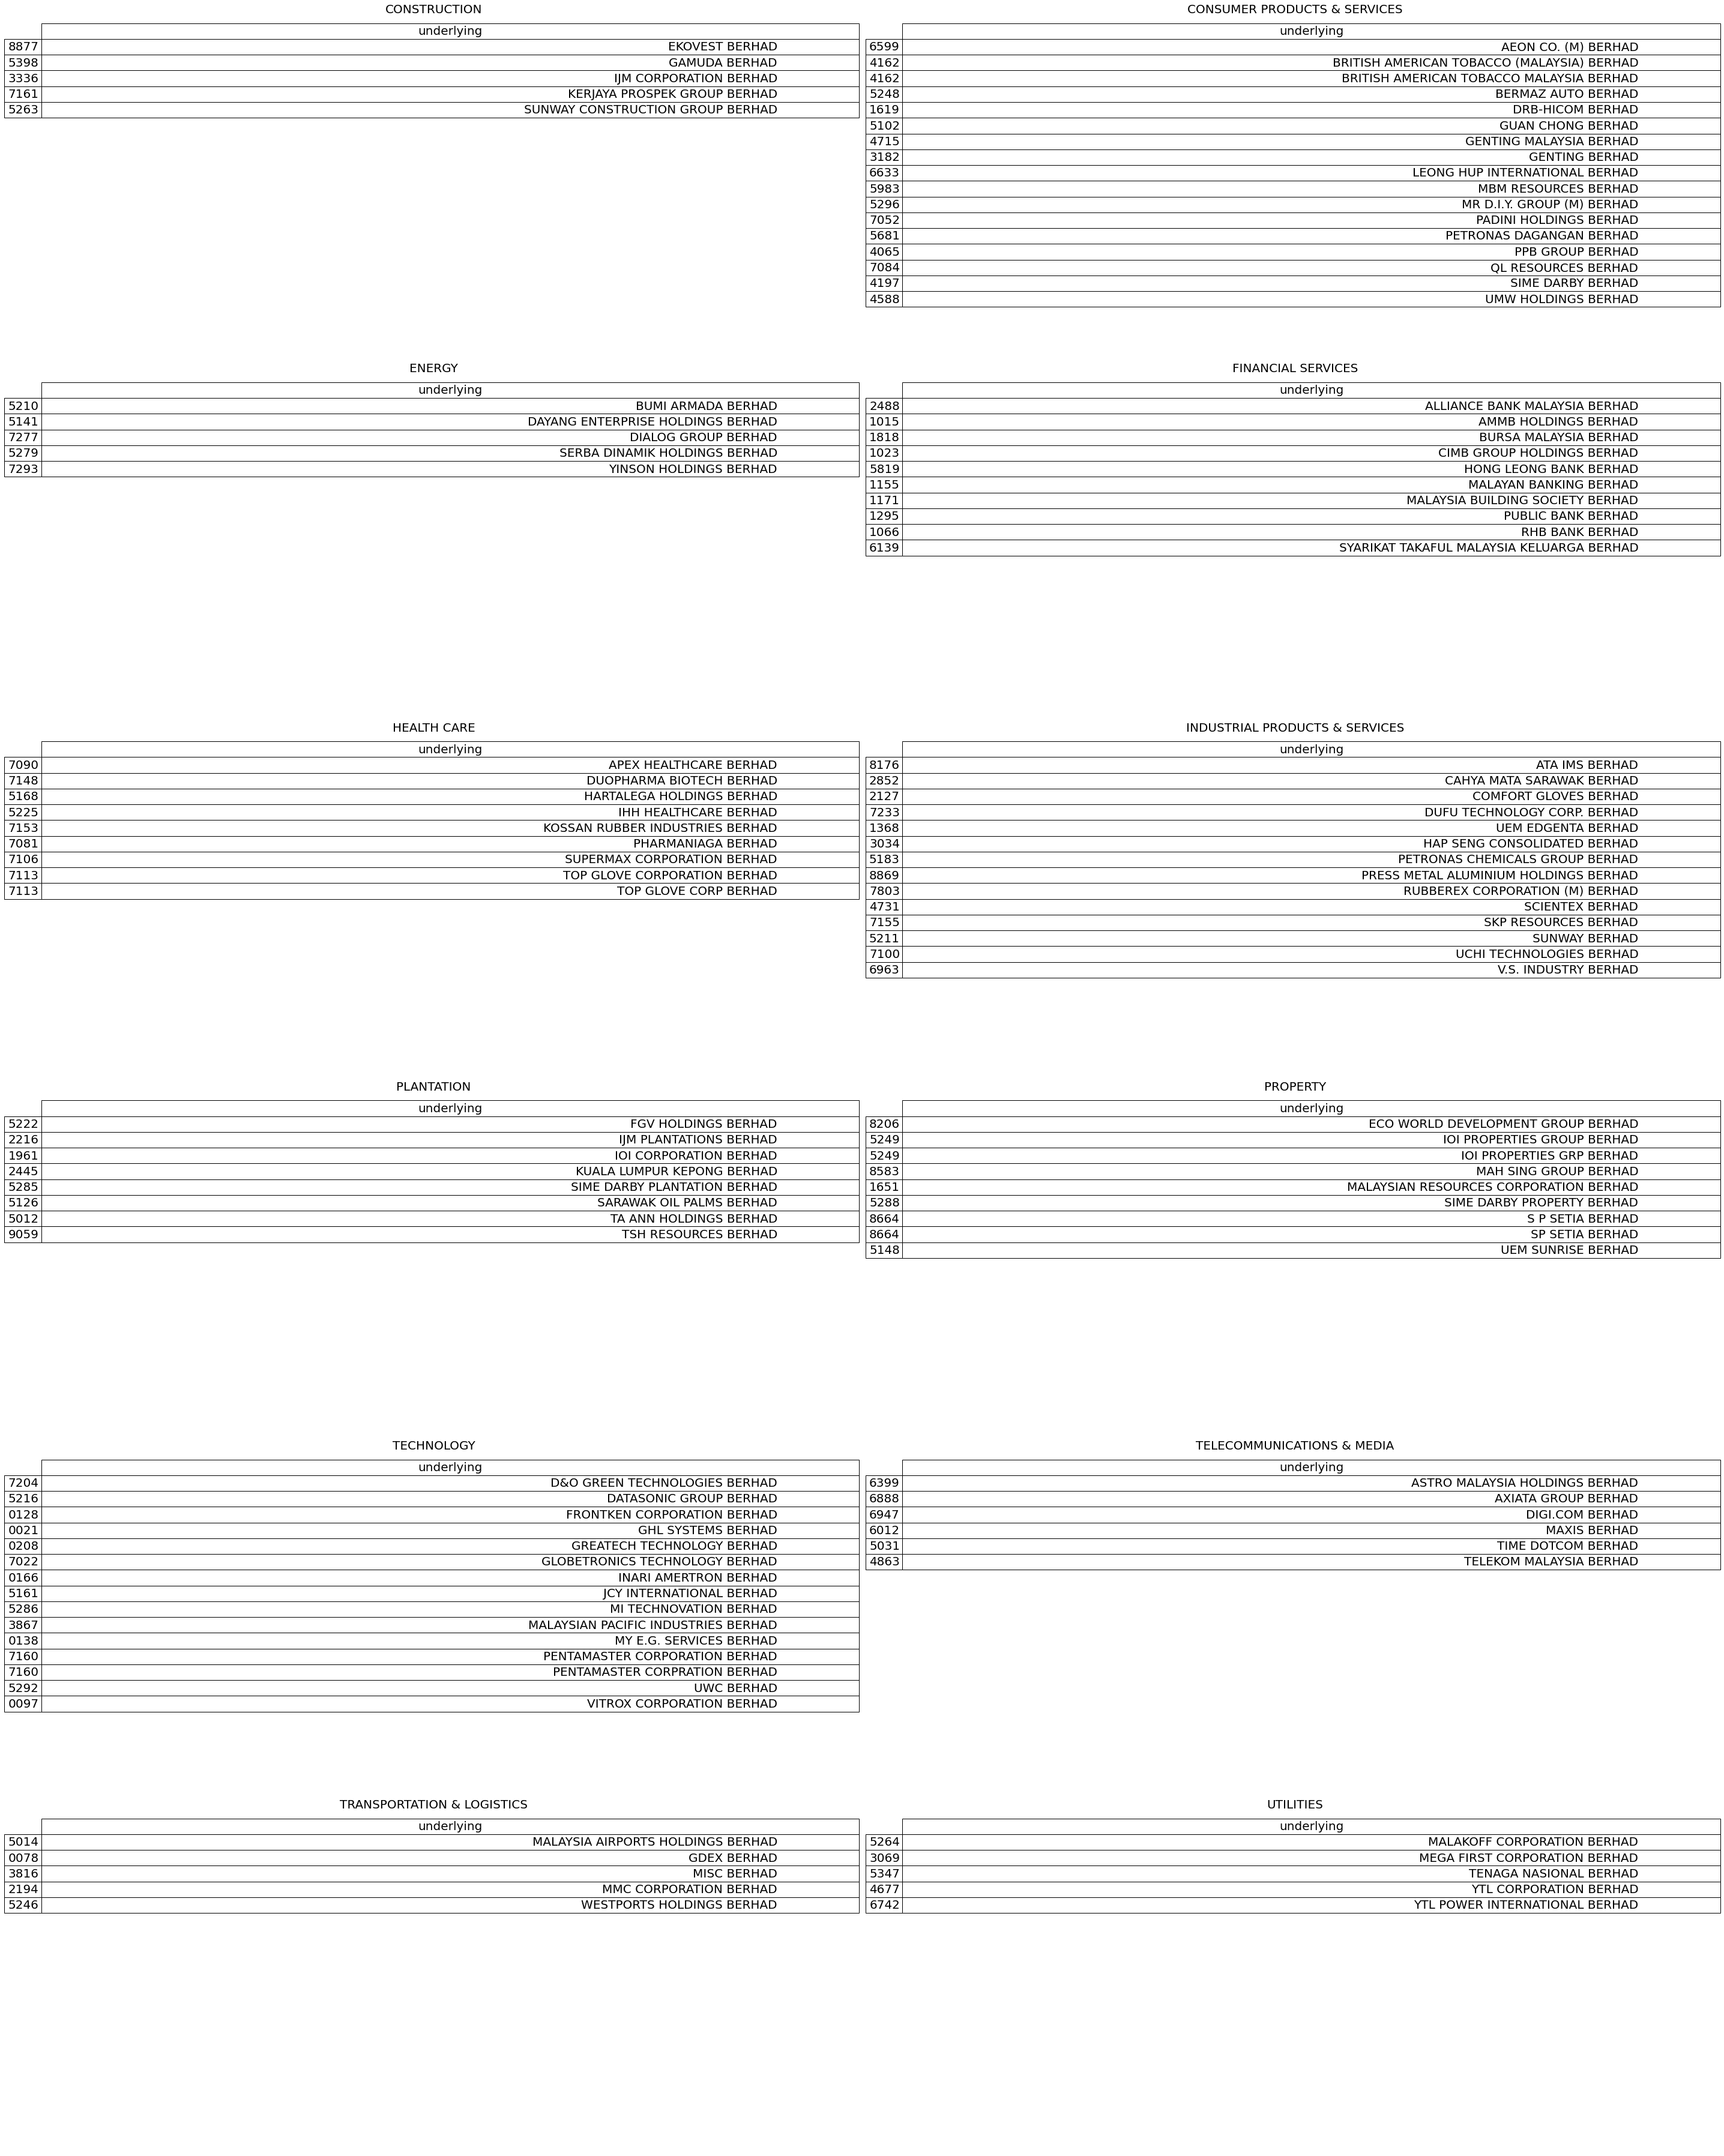

In [12]:
# there are 12 sectors as at time of writing excluding structured warrants
fig, axs = plt.subplots(6,2, figsize=(40, 50))

axs = axs.ravel()

all_sectors = sorted(df["sector"].drop_duplicates().tolist())
all_sectors.remove("STRUCTURED WARRANTS")


for i, sector in enumerate(all_sectors):
    underlying = df.query("sector == @sector")[["underlying"]].drop_duplicates()
    underlying = underlying.set_index(underlying.index.map(lambda x: x[:4]))
    
    ax = axs[i]
    
    tbl = ax.table(cellText=underlying.values,colLabels=underlying.columns,rowLabels=underlying.index,loc="upper left")
    tbl.set_fontsize(20)
    tbl.scale(1, 1.5) 
    
    ax.axis('tight')
    ax.axis('off')
    ax.set_title(sector, fontsize = 20)



plt.tight_layout()
plt.show()